In [1]:
import gymnasium as gym
from IPython.display import display, clear_output, Image
import pathlib
import sys
import torch
from torch.utils.tensorboard import SummaryWriter
import tqdm
sys.path.insert(0, str(pathlib.Path("../..").absolute()))

from environment import TreeEnv
from analysis import DataLogger, SystemMetrics, LearningMetrics, plot_system_metrics, plot_train_metrics
from computation_sim.system import SystemDrawer, GifCreator
from agents.q_agent import DQNActor


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = pathlib.Path("models")
MODEL_PATH.mkdir(exist_ok=True)
LOG_PATH = pathlib.Path("logs")
LOG_PATH.mkdir(exist_ok=True)
MODEL_NAME = "model_0"
print(f"Using device: {DEVICE}")


Using device: cuda


In [2]:

def simulate(env: TreeEnv, num_steps: int, gif_creator: GifCreator):
    state, _ = env.reset()
    state = torch.tensor(state.data, dtype=torch.float32, device=DEVICE).unsqueeze(0)
    drawer = SystemDrawer()
    drawer.build(env.system.node_graph)
    gif_creator.update(drawer)

    # Simulate and capture frames
    for i in range(num_steps):
        action = agent.epsilon_greedy(state)
        next_state, _, _, _, _= env.step(action)
        state = torch.tensor(
            next_state.data, dtype=torch.float32, device=DEVICE
        ).unsqueeze(0)
        drawer.update(env.system.node_graph)

        gif_creator.update(drawer)


In [3]:
def train(
    actor: DQNActor,
    env: gym.Env,
    num_sim_steps: int,
    optimize_period: int,
    logger: DataLogger = None,
    device: str = "cpu",
):
    # Initialize the environment
    state, _ = env.reset()
    state = torch.tensor(state.data, dtype=torch.float32, device=device).unsqueeze(0)

    # Run training loop
    bar = tqdm.tqdm(range(num_sim_steps))
    for i_step in bar:
        #bar.set_description(f"Time: {env.time} ms")
        # Take action, observe transition
        action = actor.epsilon_greedy(state)
        next_state, reward, _, _, info = env.step(action)

        # Update memory
        action = torch.tensor([[action]], device=device, dtype=torch.int64)
        next_state = torch.tensor(
            next_state.data, dtype=torch.float32, device=device
        ).unsqueeze(0)
        reward = torch.tensor([reward], device=device)
        actor.push_memory(state, action, next_state, reward)

        # Run learning algo
        if logger is not None:
            logger.log_system_metrics(env.time, SystemMetrics(**info))
        if i_step % optimize_period == 0:
            learning_info = actor.optimize_model()
            if len(learning_info) != 0 :
                logger.log_train_metrics(env.time, LearningMetrics(**learning_info, reward=reward.cpu().item()))
        logger.write_to_tensorboard(i_step)

        # Close loop
        state = next_state

In [4]:
dt = 10 # Time step is 10 ms
params = {
    "environment" : {
        "num_sensors": 5,
        "dt": dt,
        "cost_input": 0.01,
        "cost_message_loss": 1.0,
        "cost_output_time": 0.1 / 100.0,
    },
    "actor" : {
        "learn_period": int(100 / dt), # Update model every 100ms
        "memory_size": 2 * 60 * int(1_000 / dt), # Memory spans a period of 2 minutes,
        "tau" : dt / 2000.0, # Full model update after 2sec
        "batch_size" : 1024, # Number of samples used in one optimization
        "gamma": 0.9, # Hyperparam; not really of used in continuous task
        "epsilon_start": 0.1,
        "epsilon_end": 0.0,
        "epsilon_decay" : 4 * 60 * int(1_000 / dt), # Half-life of epsilon decay: 4 minutes
        "lr" : 1e-3,
    },
    "num_sim_steps": int(3_600_000 / dt) # train for 1h

}

In [5]:
env = TreeEnv(**params["environment"])
drawer = SystemDrawer()
drawer.build(env.system.node_graph)
drawer.fw.update_layout(autosize=True, width=400, height=400)
clear_output(wait=True)
display(drawer.fw)

FigureWidget({
    'data': [{'hoverinfo': 'none',
              'line': {'color': '#888', 'width': 1.0},
              'mode': 'lines',
              'showlegend': False,
              'type': 'scatter',
              'uid': 'fff06187-a654-43b5-8fd3-997960010f27',
              'x': [0.4642857142857143, 0.9642857142857143, None,
                    0.4642857142857143, 0.9642857142857143, None,
                    -0.5357142857142857, -0.035714285714285726, None,
                    -0.035714285714285726, 0.4642857142857143, None,
                    -0.035714285714285726, 0.4642857142857143, None,
                    -0.5357142857142857, -0.035714285714285726, None,
                    -0.035714285714285726, 0.4642857142857143, None,
                    -0.035714285714285726, 0.4642857142857143, None,
                    -0.5357142857142857, -0.035714285714285726, None,
                    -0.035714285714285726, 0.4642857142857143, None,
                    -0.035714285714285726, 0.464

In [6]:
agent = DQNActor(num_states=env.observation_space.shape[0], num_actions=env.action_space.n, device=DEVICE, **params["actor"])

`tensorboard --logdir code/notebooks/01_simple_tree/logs/`

In [7]:
# Logging:
#   100 time-steps (=1s) window
#   Log to tensorboard every 100 time-steps (=1s)
writer = SummaryWriter(log_dir=str(LOG_PATH / MODEL_NAME))
logger = DataLogger(window_size=100, tensorboard_writer=writer, tensorboard_period=100)
train(
    agent,
    env,
    180_00,
    params["actor"]["learn_period"],
    logger=logger,
    device=DEVICE
)
torch.save(agent.target_net.state_dict(), str(MODEL_PATH / f"{MODEL_NAME}.mdl"))

100%|██████████| 18000/18000 [00:06<00:00, 2775.17it/s]


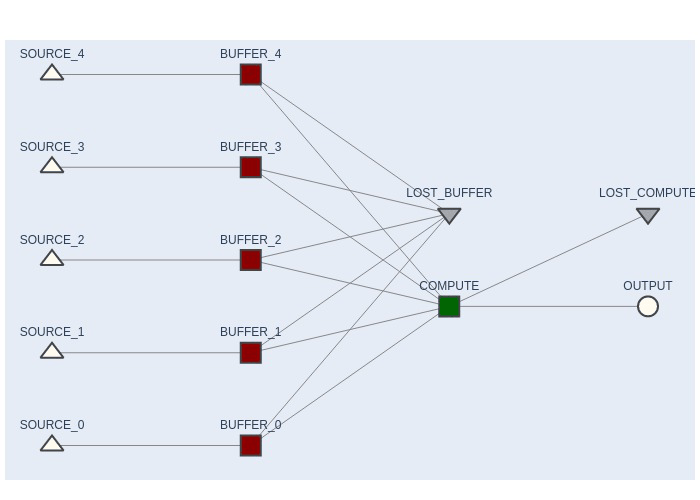

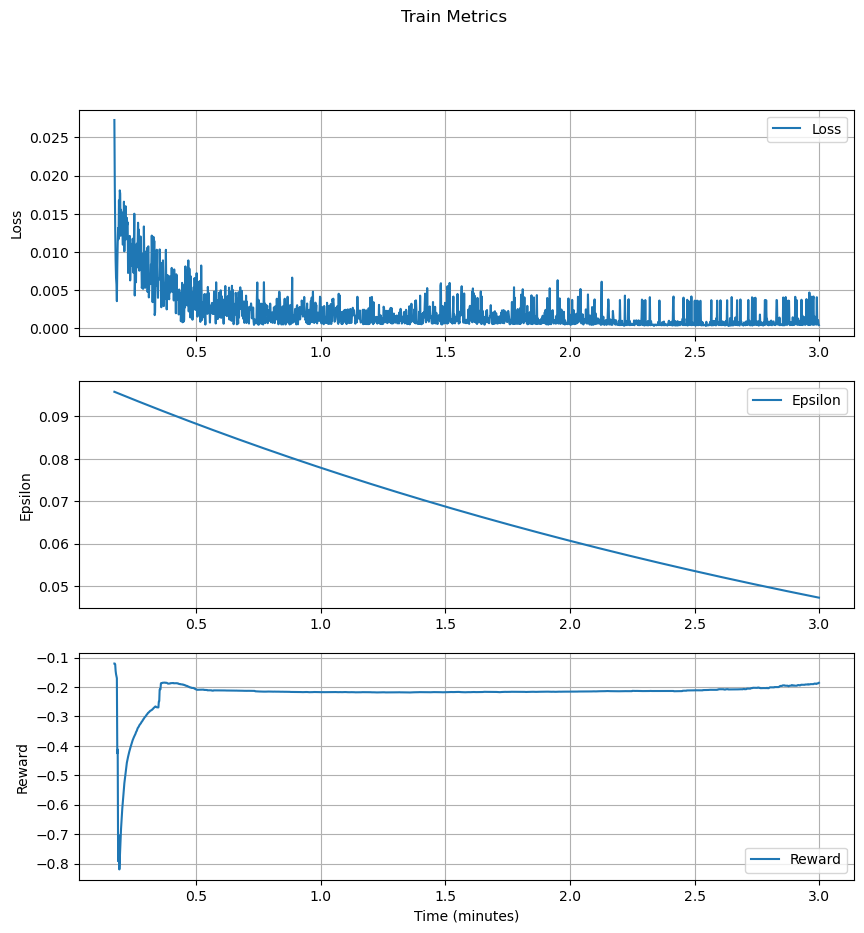

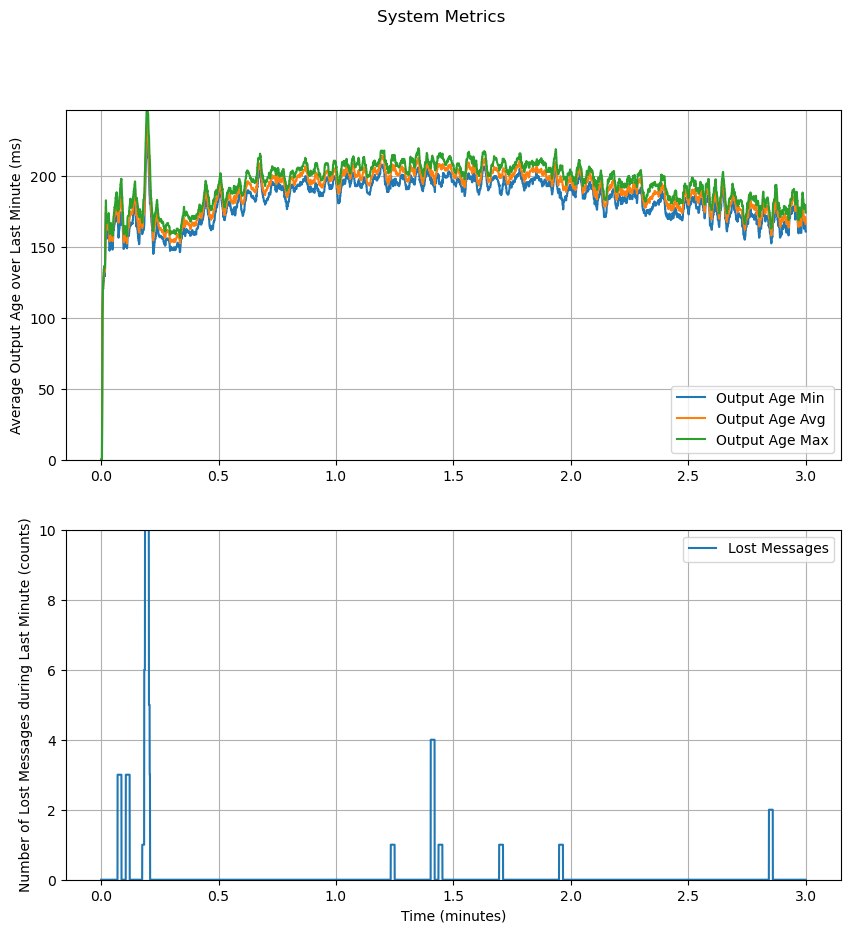

In [8]:
plot_train_metrics(logger)
plot_system_metrics(logger)
gif_creator = GifCreator()
simulate(env, 100, gif_creator=gif_creator)
gif_creator.save("simulation.gif")
with open('simulation.gif','rb') as f:
    display(Image(data=f.read(), format='png'))

